<a href="https://colab.research.google.com/github/kaylil/Audio-Speech-Separation/blob/master/APS360_Audio_Project_Extended_(Data_Generation_Preprocessing_Baseline_Presentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pydub
!pip install sphfile
!pip install wavio

  Created wheel for sphfile: filename=sphfile-1.0.1-cp36-none-any.whl size=3720 sha256=39fb0f60be871e8c76b4de94e286136947f41f797194c41d74aa6ca68abdc5ae
  Stored in directory: /root/.cache/pip/wheels/73/a8/71/e339da6bfe707de7c5d1631750b163f36b6ec14efe48f97ec1
Successfully built sphfile


In [0]:
#Imports
import imp
import random
import pickle
import wavio
import math
import os
import shutil
import datetime
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy

from scipy import signal
#from sphfile import SPHFile
# from chamfer_distance import ChamferDistance

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from pydub import AudioSegment

import pickle
random.seed(42)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def createDictionarOnlyFirst(directory):
    #This function takes in a path which contains overlaid files and outputs a 
    #dictionary with Person1 as a key and the path of the overlaid file as the value
    dictionary = {}
    
    for filename in os.listdir(directory):
        _, person1, _, dialect2, person2, _ = getOverlayFileInfo(filename)
        path1, path2 = getPathsFromOverlayFile(filename)
        if (person1 not in dictionary):
            dictionary[person1] = []
            dictionary[person1].append(path2)
        else:
            dictionary[person1].append(path2)
    return dictionary
  
def move():
  #This function is for moving all 100,000 files into 10 separate folders, onee at a time.
  os.mkdir("/content/gdrive/My Drive/APS360 Project/Data/Files 9")
  i = 0
  for file in os.listdir("/content/gdrive/My Drive/APS360 Project/Data/Generated Dataset/"):
    if i > 9307:
      break
    if i%500 == 0:
      currentDT = datetime.datetime.now()
      print(i, " Time -- ", currentDT.hour, ":", currentDT.minute)
    oldPath = "/content/gdrive/My Drive/APS360 Project/Data/Generated Dataset/" + file
    newPath = "/content/gdrive/My Drive/APS360 Project/Data/Files 9"
    shutil.move(oldPath, newPath)
    i+=1

def nameOverlayFile(path1, path2):    
    #This function takes two file paths and outputs the name of their overlay
    dialect1, person1, sentence1 = getFileInfo(path1)
    dialect2, person2, sentence2 = getFileInfo(path2)
    new_file_name = dialect1 + "_" + person1 + "_" + sentence1 + "_" + dialect2 + "_" + person2 + "_" + sentence2
    return new_file_name
    
def getFileInfo(path):
    #This function take a path of a file and returns its details by splitting the file's name
    tokens = path.split("/")
    dialect = tokens[-3]
    person = tokens[-2]
    sentence = tokens[-1].split(".")[0]
    return dialect, person, sentence
  
def getOverlayFileInfo(path):
    #This function takes the path of an overlay file and returns its details by splitting its name
    tokens = path.split("_")
    # return strings in the order of: dialect1, person1, sentence1,dialect2, person2, sentence2
    return tokens[-6], tokens[-5], tokens[-4], tokens[-3], tokens[-2], tokens[-1].split(".")[0]
    
def getPathsFromOverlayFile(oFileName, directory="/content/gdrive/My Drive/APS360 Project/Data/data/lisa/data/timit/raw/TIMIT/TRAIN/"):
    #This function takes in an overlay file's name and returns the paths of the two files it was generated from
    #oFileName can be either the name or path (with "/" at the end) of the overlay file
    dialect1, person1, sentence1, dialect2, person2, sentence2 = getOverlayFileInfo(oFileName)
    path1 = directory + dialect1 + "/" + person1 + "/" + sentence1 + ".WAV"
    path2 = directory + dialect2 + "/" + person2 + "/" + sentence2 + ".WAV"
    return path1, path2
    
def getSpeakers(oFileName):
    #This function takes in an overlay file's name and returns the two people's IDs that were used to generate it
    tokens = oFileName.split("_")
    person1 = tokens[1]
    person2 = tokens[4]
    return person1, person2


def createDictionary(directory):
    #This function takes in a path to overlaid files and returns a dictionary with 
    #people as keys and every overlay file they were part of as their values 
    dictionary = {}
    
    for filename in os.listdir(directory):
        person1, person2 = getSpeakers(filename)
        path1, path2 = getPathsFromOverlayFile(filename)
        if (person1 not in dictionary):
            dictionary[person1] = []
            dictionary[person1].append(path2)
        else:
            dictionary[person1].append(path2)
        if (person2 not in dictionary):
            dictionary[person2] = []
            dictionary[person2].append(path1)
        else:
            dictionary[person2].append(path1)
    return dictionary
    
#Overlay Generation

#check short vs long wav files
#overlay short on long 
#Make File Name
#export it to a folder using file name
#make dictionary
#export dictionary to file

def GenerateOverlay(wav1_Path, wav2_Path):
  #This function takes two paths to wav files and generates and exports an overlay file
  sound1 = AudioSegment.from_file(wav1_Path)
  sound2 = AudioSegment.from_file(wav2_Path)
  if len(sound1) > len(sound2):
    overlaied = sound1.overlay(sound2)
  else: 
    overlaied = sound2.overlay(sound1)
    
  file_handle = overlaied.export("/content/gdrive/My Drive/APS360 Project/Data/Generated Dataset/" + nameOverlayFile(wav1_Path, wav2_Path), format="wav")
  return 

def MainGenerateData(main_path):
  #This function generated all of our data. It was called twice, once for the training set and once for the testing set
  people_paths = []
  for DRx in os.listdir(train_path):                        #loop over everyone in the set
    for person in os.listdir(train_path + DRx):             
      people_paths.append(train_path + DRx + '/' + person)  #append every person's path to a list
  print("All people paths collected...")

  person_to_wavs = dict()                             #dictionary with people's paths as keys, and wav file as values
  for person_path in people_paths:                    #for every person in the data
    person_wavs = []                                  #empty list for this person's WAV files
    for file in os.listdir(person_path):              #for all this peron's files
      if file.endswith("WAV"):                        #find all the WAV files
        person_wavs.append(person_path + '/' + file)  #add all the WAV file paths to a list
    person_to_wavs[person_path] = person_wavs         #{ person's path:[list of their WAV paths] }
  print("Person to WAVs dictionary complete...")
  
  total_files_generated = 0
  for i in range(0, len(people_paths)):                              #for every person
    files_generated_for_this_person = 0
    random_wav_i = random.choice(person_to_wavs[people_paths[i]])    #randomly select one of their wav files
    for j in range(i+1, len(people_paths)):                          #for the remaining people
      random_wav_j = random.choice(person_to_wavs[people_paths[j]])  #randomly select one of their wav files
      GenerateOverlay(random_wav_i, random_wav_j)                    #Overlay one wav on the other
      files_generated_for_this_person += 1
    total_files_generated += files_generated_for_this_person
    print("Completed person ", i+1, " | Files Generated: ", files_generated_for_this_person, " | Total Files: ", total_files_generated)
    
class DataFile(Dataset):
  def __init__(self, data_folder, transform=None): 
    dataset = "TRAIN"
    truths_folder = "./Data/data/lisa/data/timit/raw/TIMIT/" + dataset + "/"

    self.__xs = [] 
    self.__ys = [] 
    i = 0
    numChunks = 0
    for file in os.listdir(data_folder):
      if file != ".DS_Store":
        path_overlay = data_folder + "/" + file
        path_file1, path_file2 = getPathsFromOverlayFile(file, directory=truths_folder )

        array_overlay = np.array(AudioSegment.from_file(path_overlay).get_array_of_samples())
        array_file1 = np.array(AudioSegment.from_file(path_file1).get_array_of_samples())
        array_file2 = np.array(AudioSegment.from_file(path_file2).get_array_of_samples())

        tensor_overlay = torch.tensor(array_overlay)
        tensor_file1 = torch.tensor(array_file1)
        tensor_file2 = torch.tensor(array_file2)

        number_of_chunks = math.ceil(max(len(tensor_overlay), len(tensor_file1), len(tensor_file2))/16000)

        chunks_overlay = chunkate(tensor_overlay, number_of_chunks)
        chunks_file1 = chunkate(tensor_file1, number_of_chunks)
        chunks_file2 = chunkate(tensor_file2, number_of_chunks)

        self.__xs.extend(chunks_overlay)
        for chunk in range(len(chunks_file1)):
          self.__ys.append((chunks_file1[chunk], chunks_file2[chunk]))
          numChunks += 1
        i+=1
        if i % 100 == 0: 
          print("File ", i, " | Number of Chunks Generated: ", numChunks)

  def __getitem__(self, index):
    output1 = self.__xs[index]
    truth = self.__ys[index]
    return output1, truth

  def __len__(self):
    return len(self.__xs)
  
def matchSize(a, b):
  result = torch.zeros(b.shape)
  result[:a.shape[0],:a.shape[1],:a.shape[2]] = a
  return result

def matchAll(a, b, c,d):
  lens = np.array([a.shape[2], b.shape[2], c.shape[2], d.shape[2]])
  largest_index = lens.argmax()
  all_inputs = [a,b,c,d]
  a = matchSize(a, all_inputs[largest_index])
  b = matchSize(b, all_inputs[largest_index])
  c = matchSize(c, all_inputs[largest_index])
  d = matchSize(d, all_inputs[largest_index])
  return a,b,c,d


def chunkate(tensor, number_of_chunks):
  padded_tensor = torch.zeros(number_of_chunks * 16000)
  padded_tensor[:len(tensor)] = tensor
  chunks = []
  for chunk in range(number_of_chunks):
    chunks.append(padded_tensor[chunk * 16000: (chunk+1) *16000])
  return chunks


In [0]:
overfit_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/One File/")
overfit_loader = DataLoader(overfit_set, batch_size=1, shuffle=False, num_workers=0)
print(len(overfit_set))

train_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/Train/")
train_loader = DataLoader(train_set, batch_size=5, shuffle=False, num_workers=0)
print(len(train_set))

val_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/Validation/")
val_loader = DataLoader(val_set, batch_size=5, shuffle=False, num_workers=0)
print(len(val_set))

In [0]:
train_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Train/")
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
print(len(train_set))

val_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Val/")
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)
print(len(val_set))

test_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Test/")
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0)
print(len(test_set))

In [0]:
path = '/content/gdrive/My Drive/APS360 Project/Data/dataset_cropped.backup'
with open(path, 'rb') as f:
  data_set = torch.load(f)
  
path = '/content/gdrive/My Drive/APS360 Project/Data/testset 16000.backup'
with open(path, 'rb') as f:
  test_set = torch.load(f)

In [0]:
path = '/content/gdrive/My Drive/APS360 Project/Data/dataset_SPSS.backup'
with open(path, 'rb') as f:
  data_set = torch.load(f)

In [0]:
path = '/content/gdrive/My Drive/APS360 Project/Data/dataset_OneFile.backup'
with open(path, 'rb') as f:
  overfit_set = torch.load(f)

In [0]:
print(len(data_set))
print(len(data_set)*0.75)
print(len(data_set)*0.25)

21004
15753.0
5251.0


In [0]:
print(len(test_set))
print(len(test_set)*0.75)
print(len(test_set)*0.25)

5253
3939.75
1313.25


In [0]:
overfit_loader = DataLoader(overfit_set, batch_size=1, shuffle=True, num_workers=0)

In [0]:
#16000
train_set, val_set = torch.utils.data.random_split(data_set, (15753, 5251))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_set, batch_size=64, shuffle=True, num_workers=0)

test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)

In [0]:
#160
train_set, val_set = torch.utils.data.random_split(data_set, (1948647, 649549))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_set, batch_size=64, shuffle=True, num_workers=0)

In [0]:
#SPSS
train_set, val_set = torch.utils.data.random_split(data_set, (668, 222))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_set, batch_size=64, shuffle=True, num_workers=0)

In [0]:
class KhaledNetRNN4(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN4, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN4"
    self.rnn = nn.LSTM(input_size, 2 * hidden_size, batch_first=True, num_layers=3)
    self.fc1_1 = nn.Linear(hidden_size, 1500)
    self.fc1_2 = nn.Linear(1500, input_size)

    self.fc2_1 = nn.Linear(hidden_size, 1500)
    self.fc2_2 = nn.Linear(1500, input_size)


  
  def forward(self, x):
    h0 = torch.zeros(3, x.size(0), 2*self.hidden_size)
    c0 = torch.zeros(3, x.size(0), 2*self.hidden_size)
    hiddenstates, _ = self.rnn(x, (h0, c0))
    output1 = F.relu(self.fc1_1(hiddenstates[:, -1, :50]))
    output1 = self.fc1_2(output1)
    
    output2 = F.relu(self.fc2_1(hiddenstates[:, -1, 50:]))
    output2 = self.fc2_2(output2)
    
    output = torch.cat((output1, output2), 1)
    return output

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4): 
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)        
  loss_counter = 0

  train_losses = []
  val_losses = []
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:
      model.train()
      pred = model(batchData.unsqueeze(1).float())

      pred1 = pred[:, :16000].float() * batchData.float()
      pred2 = pred[:, 16000:].float() * batchData.float()

      loss1 = criterion(pred1, truth1.float())
      loss2 = criterion(pred2, truth2.float())
      
      loss3 = criterion(pred1, truth2.float())
      loss4 = criterion(pred2, truth1.float())
      
      separation_loss = criterion(pred1, pred2)
      recon_loss = criterion(pred1 + pred2, batchData.float())
      chamfer_loss = min(loss1+loss2, loss3+loss4)
      
      total_loss = (recon_loss+chamfer_loss-0.15*separation_loss)/len(batchData)

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      train_losses.append(get_loss(model, train_loader).item())
      val_losses.append(get_loss(model, valid_loader).item())
      
      loss_counter += 1
      if loss_counter % 200 == 0:
        plt.title("Training Curve")
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Validation")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
      if loss_counter % 50 == 0:
        print("Iteration ", loss_counter, " | Loss: ", total_loss.item())

def get_loss(model, data_loader, chunk_size=16000):
  MSE_criterion = nn.MSELoss()
  criterion2 = nn.KLDivLoss()
  model.eval()
  for batchData, (truth1, truth2) in data_loader:  
    pred = model(batchData.unsqueeze(1).float())

    # Loss of MSE Loss 
    MSE_loss1 = MSE_criterion(pred[:, :chunk_size].float() * batchData.float(), truth1.float())
    MSE_loss2 = MSE_criterion(pred[:, chunk_size:].float() * batchData.float(), truth2.float())
    MSE_loss3 = MSE_criterion(pred[:, :chunk_size].float() * batchData.float(), truth2.float())
    MSE_loss4 = MSE_criterion(pred[:, chunk_size:].float() * batchData.float(), truth1.float())
    
    chamfer_loss = min(MSE_loss1+MSE_loss2, MSE_loss3+MSE_loss4)
    batch_loss = (chamfer_loss)/len(batchData)
    break
  return batch_loss

def output_results(model, data_loader):
  i = 0
  for batchData, (truth1, truth2) in data_loader:
    if i == 0:
      out_overlay = batchData.numpy().astype("int16")[0]
      out_truth1 = truth1.numpy().astype("int16")[0]
      out_truth2 = truth2.numpy().astype("int16")[0]

      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/out_overlay.wav", out_overlay, 16000)
      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/out_truth1.wav", out_truth1, 16000)
      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/out_truth2.wav", out_truth2, 16000)

      masks = model(batchData.unsqueeze(1).float())

      output1 = batchData[0].float() * masks[0][:16000]
      output2 = batchData[0].float() * masks[0][16000:]

      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/output1.wav", output1.detach().numpy().astype("int16"), 16000)
      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/output2.wav", output2.detach().numpy().astype("int16"), 16000)
      print("Done output")
      break
    i+=1


In [0]:
model = KhaledNetRNN4(16000, 50)

Iteration  50  | Loss:  6152.72412109375
Iteration  100  | Loss:  2351.820068359375
Iteration  150  | Loss:  1292.51123046875


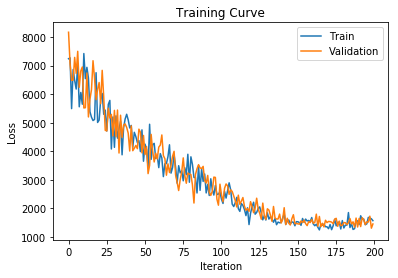

Iteration  200  | Loss:  616.2855224609375
Iteration  250  | Loss:  56.8114013671875
Iteration  300  | Loss:  518.6707763671875
Iteration  350  | Loss:  359.07958984375


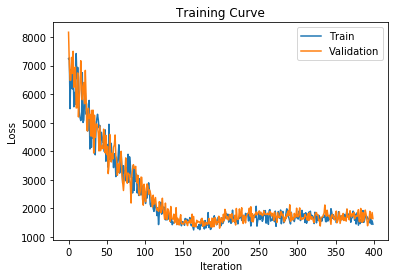

Iteration  400  | Loss:  401.872802734375
Iteration  450  | Loss:  59.8282470703125
Iteration  500  | Loss:  302.631591796875
Iteration  550  | Loss:  153.42550659179688


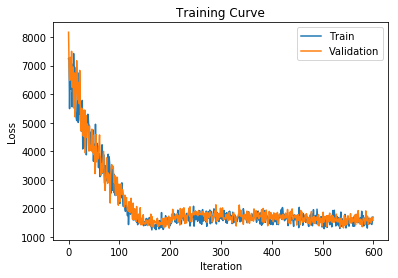

Iteration  600  | Loss:  -18.3309326171875
Iteration  650  | Loss:  189.0028076171875
Iteration  700  | Loss:  310.0791015625
Iteration  750  | Loss:  -37.1773681640625


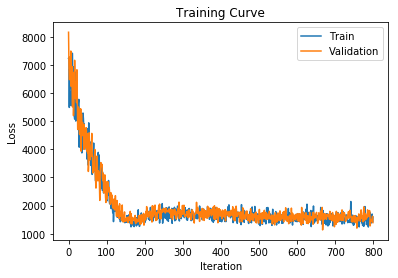

Iteration  800  | Loss:  60.9822998046875
Iteration  850  | Loss:  102.906982421875
Iteration  900  | Loss:  155.424072265625
Iteration  950  | Loss:  175.933349609375


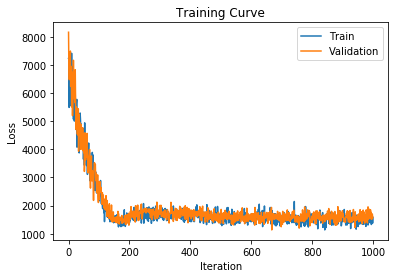

Iteration  1000  | Loss:  11.208984375
Iteration  1050  | Loss:  50.6890869140625
Iteration  1100  | Loss:  648.8150024414062
Iteration  1150  | Loss:  182.888427734375


KeyboardInterrupt: ignored

In [0]:
train(model, train_loader, valid_loader, num_epochs=1000, learning_rate=1e-4)

In [0]:
output_results(model, train_loader)

Done output


In [0]:
class KhaledNetRNN4_cuda(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN4_cuda, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN4_cuda"
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2)
    self.fc = nn.Linear(hidden_size, input_size*2)
    self.dropout = nn.Dropout(0.4)

  
  def forward(self, x):
    h0 = torch.zeros(2, x.size(0), self.hidden_size)
    output, _ = self.rnn(x.cuda(), h0.cuda())
    output = self.fc(self.dropout(output[:, -1, :]))
    return output

def get_loss(model, data_loader, chunk_size=16000):
  MSE_criterion = nn.MSELoss()
  criterion2 = nn.KLDivLoss()
  model.eval()
  for batchData, (truth1, truth2) in data_loader:  
    pred = model(batchData.unsqueeze(1))

    # Loss of MSE Loss 
    MSE_loss1 = MSE_criterion(pred[:, :chunk_size].float() * batchData, truth1)
    MSE_loss2 = MSE_criterion(pred[:, chunk_size:].float() * batchData, truth2)
    #     loss3 = MSE_criterion(pred[:, :chunk_size].float() * batchData.cuda(), truth2.cuda())
    #     loss4 = MSE_criterion(pred[:, chunk_size:].float() * batchData.cuda(), truth1.cuda())
    
    batch_loss = (MSE_loss1 +  MSE_loss2)/len(batchData)
    break
  return batch_loss

def train_cuda(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  model.cuda()
  MSE_criterion = nn.MSELoss()
  KL_criterion = nn.KLDivLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  loss_counter = 0
  chunk_length = 16000
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:
      model.train()
      pred = model(batchData.unsqueeze(1).float().cuda())

      pred1 = pred[:, chunk_length*0:chunk_length*1].float() * batchData.float().cuda()
      pred2 = pred[:, chunk_length*1:chunk_length*2].float() * batchData.float().cuda()

      mse_loss1 = MSE_criterion(pred1, truth1.float().cuda())
      mse_loss2 = MSE_criterion(pred2, truth2.float().cuda())
      
      mse_loss3 = MSE_criterion(pred1, truth2.float().cuda())
      mse_loss4 = MSE_criterion(pred2, truth1.float().cuda())
      
      MSE_chamfer_loss = min(mse_loss1 + mse_loss2, mse_loss3 + mse_loss4)
      
      
      KL_loss1 = abs(KL_criterion(pred1, truth1.float().cuda()))
      KL_loss2 = abs(KL_criterion(pred2, truth2.float().cuda()))
      
      KL_loss3 = abs(KL_criterion(pred1, truth2.float().cuda()))
      KL_loss4 = abs(KL_criterion(pred2, truth1.float().cuda()))
      
      KL_chamfer_loss = min(KL_loss1 + KL_loss2, KL_loss3 + KL_loss4)

      
      MSE_recon_loss = MSE_criterion(pred1 + pred2, batchData.float().cuda())
      KL_recon_loss = abs(KL_criterion(pred1 + pred2, batchData.float().cuda()))
            
      #total_loss = (MSE_chamfer_loss + KL_chamfer_loss)/len(batchData)
      
      total_loss = (mse_loss1 + mse_loss2) /len(batchData)
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      train_losses.append(get_loss_cuda(model, train_loader).item())
      val_losses.append(get_loss_cuda(model, valid_loader).item())
      
      loss_counter += 1
      if loss_counter % 200 == 0:
        plt.title("Training Curve")
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Validation")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
        
      if loss_counter % 50 == 0:
        print("Iteration ", loss_counter, " | Loss: ", total_loss.item())

def get_loss_cuda(model, data_loader, chunk_size=16000):
  MSE_criterion = nn.MSELoss()
  criterion2 = nn.KLDivLoss()
  model.eval()
  chunk_length = 16000
  for batchData, (truth1, truth2) in data_loader:  
    pred = model(batchData.unsqueeze(1).float().cuda())

    pred1 = pred[:, chunk_length*0:chunk_length*1].float() * batchData.float().cuda()
    pred2 = pred[:, chunk_length*1:chunk_length*2].float() * batchData.float().cuda()

    mse_loss1 = MSE_criterion(pred1, truth1.float().cuda())
    mse_loss2 = MSE_criterion(pred2, truth2.float().cuda())

    mse_loss3 = MSE_criterion(pred1, truth2.float().cuda())
    mse_loss4 = MSE_criterion(pred2, truth1.float().cuda())
    
    MSE_chamfer_loss = min(mse_loss1 + mse_loss2, mse_loss3 + mse_loss4)

    batch_loss = (MSE_chamfer_loss)/len(batchData)
    break
  return batch_loss

def output_results_cuda(model, data_loader):
  i = 0
  chunk_length = 16000
  for batchData, (truth1, truth2) in data_loader:
    if i == 0:
      out_overlay = batchData.numpy().astype("int16")[0]
      out_truth1 = truth1.numpy().astype("int16")[0]
      out_truth2 = truth2.numpy().astype("int16")[0]
      
      print(out_overlay)
      print(out_truth1)
      print(out_truth2)

      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/out_overlay_LSTM.wav", out_overlay, 16000)
      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/out_truth1_LSTM.wav", out_truth1, 16000)
      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/out_truth2_LSTM.wav", out_truth2, 16000)

      pred = model(batchData.unsqueeze(1).float().cuda())
      
      output1 = pred[:, chunk_length*0:chunk_length*1].float() * batchData.float().cuda()
      output2 = pred[:, chunk_length*1:chunk_length*2].float() * batchData.float().cuda()

      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/output1_LSTM.wav", output1[0].cpu().detach().numpy().astype("int16"), 16000)
      wavio.write("/content/gdrive/My Drive/APS360 Project/Data/output2_LSTM.wav", output2[0].cpu().detach().numpy().astype("int16"), 16000)
      
      print(output1[0].cpu().detach().numpy().astype("int16"))
      print(output2[0].cpu().detach().numpy().astype("int16"))
      break
    i+=1


In [0]:
class RNN_2_cuda(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(RNN_2_cuda, self).__init__()
    self.hidden_size = hidden_size
    self.name = "RNN_2_cuda"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=2)
    self.fc = nn.Linear(hidden_size, input_size*2)
    self.dropout = nn.Dropout(0.4)

  
  def forward(self, x):
    h0 = torch.zeros(2, x.size(0), self.hidden_size)
    output, _ = self.rnn(x.cuda(), h0.cuda())
    output = self.fc(self.dropout(output[:, -1, :]))
    return output
  

class GRU_2_cuda(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(GRU_2_cuda, self).__init__()
    self.hidden_size = hidden_size
    self.name = "GRU_2_cuda"
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2)
    self.fc = nn.Linear(hidden_size, input_size*2)
    self.dropout = nn.Dropout(0.4)

  
  def forward(self, x):
    h0 = torch.zeros(2, x.size(0), self.hidden_size)
    output, _ = self.rnn(x.cuda(), h0.cuda())
    output = self.fc(self.dropout(output[:, -1, :]))
    return output

  
class LSTM_2_cuda(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(LSTM_2_cuda, self).__init__()
    self.hidden_size = hidden_size
    self.name = "LSTM_2_cuda"
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
    self.fc = nn.Linear(hidden_size, input_size*2)
    self.dropout = nn.Dropout(0.4)

  
  def forward(self, x):
    h0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
    c0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
    output, _ = self.rnn(x, (h0, c0))
    output = self.fc(self.dropout(output[:, -1, :]))
    return output
  

class LSTM_4_cuda(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(LSTM_4_cuda, self).__init__()
    self.hidden_size = hidden_size
    self.name = "LSTM_4_cuda"
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=4)
    self.fc = nn.Linear(hidden_size, input_size*2)
    self.dropout = nn.Dropout(0.4)

  
  def forward(self, x):
    h0 = torch.zeros(4, x.size(0), self.hidden_size).cuda()
    c0 = torch.zeros(4, x.size(0), self.hidden_size).cuda()
    output, _ = self.rnn(x, (h0, c0))

    output = self.fc(self.dropout(output[:, -1, :]))
    return output

In [0]:
RNN = RNN_2_cuda(16000, 500)
GRU = GRU_2_cuda(16000, 500)
LSTM1 = LSTM_2_cuda(16000, 500)
LSTM2 = LSTM_4_cuda(16000, 500)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration  50  | Loss:  16842.953125
Iteration  100  | Loss:  12811.3359375
Iteration  150  | Loss:  14242.1298828125


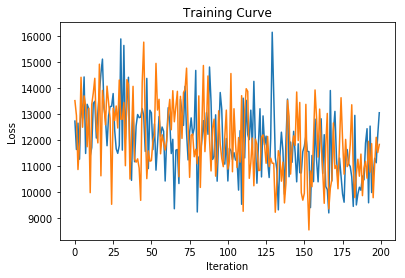

Iteration  200  | Loss:  10829.42578125
Iteration  250  | Loss:  12125.646484375
Iteration  300  | Loss:  8901.9384765625
Iteration  350  | Loss:  9716.5244140625


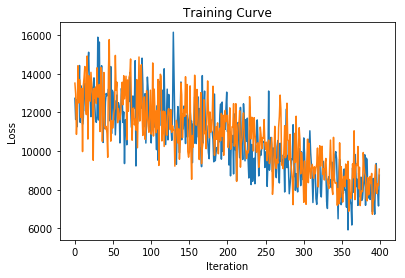

Iteration  400  | Loss:  8056.3779296875
Iteration  450  | Loss:  7817.39697265625
Iteration  500  | Loss:  6796.16796875
Iteration  550  | Loss:  7472.572265625


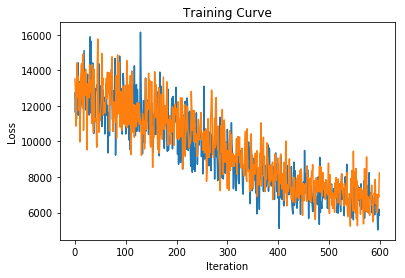

Iteration  600  | Loss:  6370.50146484375
Iteration  650  | Loss:  7922.02392578125
Iteration  700  | Loss:  8833.90625
Iteration  750  | Loss:  6339.0517578125


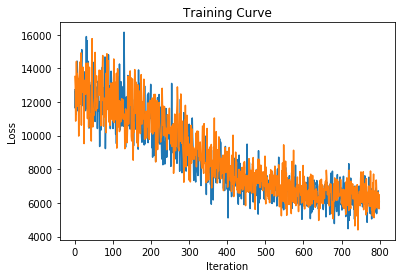

Iteration  800  | Loss:  6407.7373046875
Iteration  850  | Loss:  6392.23486328125
Iteration  900  | Loss:  6821.90234375
Iteration  950  | Loss:  7128.74658203125


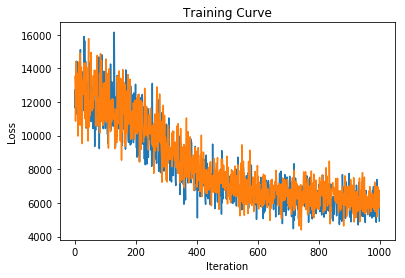

Iteration  1000  | Loss:  6598.06591796875
Iteration  1050  | Loss:  6274.873046875
Iteration  1100  | Loss:  6050.3828125
Iteration  1150  | Loss:  7310.2109375


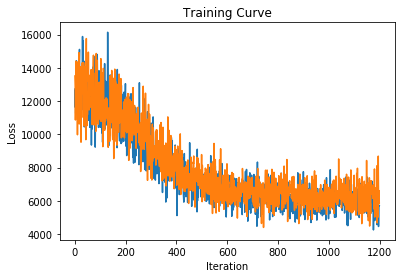

Iteration  1200  | Loss:  7127.5126953125


In [54]:
train_cuda(RNN, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration  50  | Loss:  12510.5673828125
Iteration  100  | Loss:  8969.9931640625
Iteration  150  | Loss:  10742.8671875


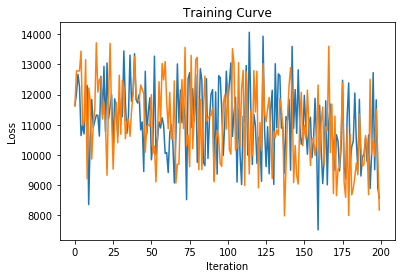

Iteration  200  | Loss:  11536.958984375
Iteration  250  | Loss:  7938.14208984375
Iteration  300  | Loss:  9253.2392578125
Iteration  350  | Loss:  7866.4189453125


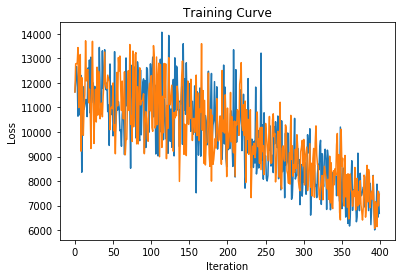

Iteration  400  | Loss:  7991.69970703125
Iteration  450  | Loss:  7699.474609375
Iteration  500  | Loss:  5519.7275390625
Iteration  550  | Loss:  7120.84326171875


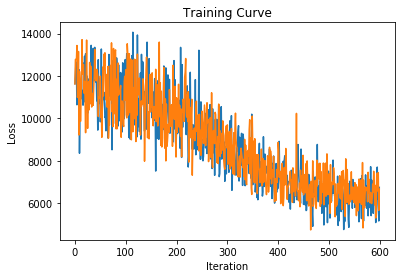

Iteration  600  | Loss:  7039.6328125
Iteration  650  | Loss:  6893.42578125
Iteration  700  | Loss:  4795.75
Iteration  750  | Loss:  5729.7021484375


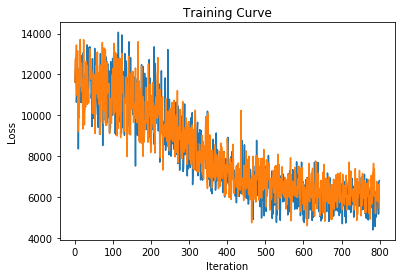

Iteration  800  | Loss:  6168.8056640625
Iteration  850  | Loss:  5957.8212890625
Iteration  900  | Loss:  5539.091796875
Iteration  950  | Loss:  4739.4052734375


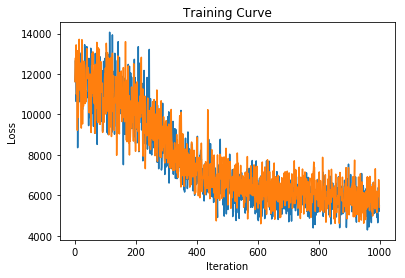

Iteration  1000  | Loss:  5834.2021484375
Iteration  1050  | Loss:  5253.6357421875
Iteration  1100  | Loss:  5485.572265625
Iteration  1150  | Loss:  5325.5908203125


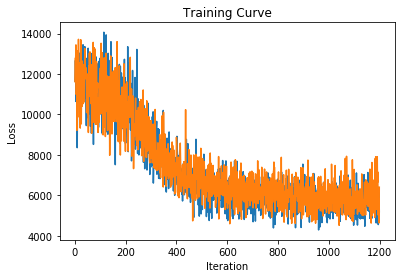

Iteration  1200  | Loss:  6486.32666015625


In [55]:
train_cuda(GRU, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration  50  | Loss:  9594.837890625
Iteration  100  | Loss:  10557.4111328125
Iteration  150  | Loss:  8414.65234375


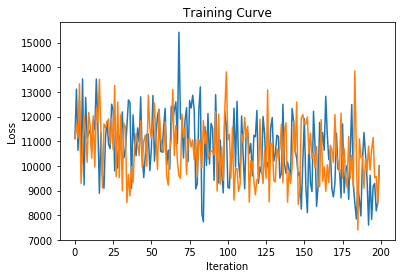

Iteration  200  | Loss:  9487.98046875
Iteration  250  | Loss:  6777.2607421875
Iteration  300  | Loss:  8802.1494140625
Iteration  350  | Loss:  7809.8251953125


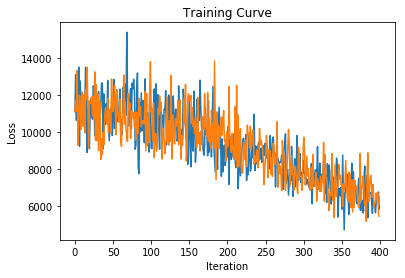

Iteration  400  | Loss:  5511.0322265625
Iteration  450  | Loss:  5137.46142578125
Iteration  500  | Loss:  6141.8798828125
Iteration  550  | Loss:  4759.525390625


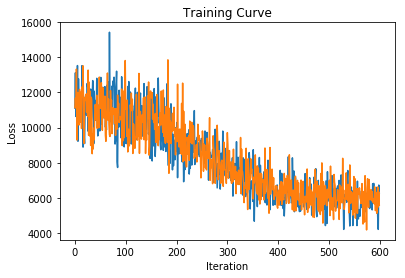

Iteration  600  | Loss:  4613.1640625
Iteration  650  | Loss:  5928.41015625
Iteration  700  | Loss:  6710.9716796875
Iteration  750  | Loss:  5800.4580078125


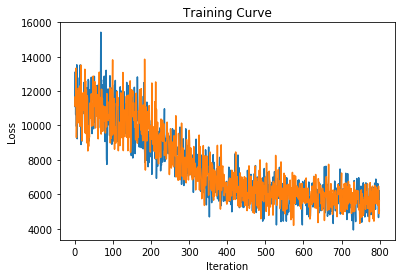

Iteration  800  | Loss:  5220.24072265625
Iteration  850  | Loss:  7164.041015625
Iteration  900  | Loss:  5160.70947265625
Iteration  950  | Loss:  6793.109375


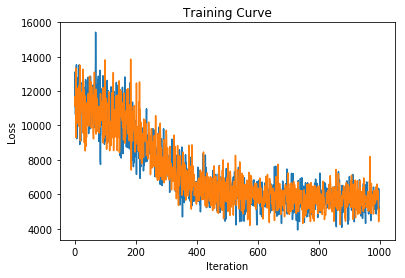

Iteration  1000  | Loss:  5890.494140625
Iteration  1050  | Loss:  6512.64453125
Iteration  1100  | Loss:  6140.43115234375
Iteration  1150  | Loss:  6100.8701171875


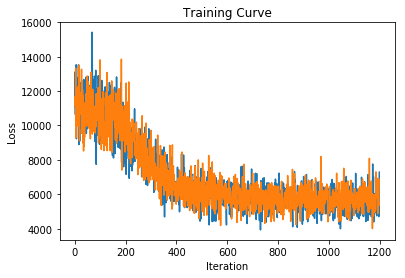

Iteration  1200  | Loss:  5466.0009765625


In [59]:
train_cuda(LSTM1, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration  50  | Loss:  11326.7734375
Iteration  100  | Loss:  5251.02197265625
Iteration  150  | Loss:  6818.1513671875


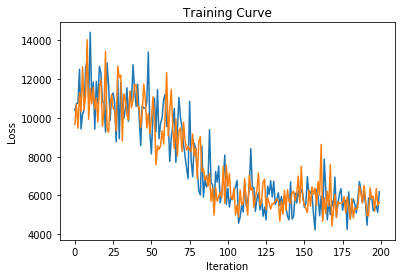

Iteration  200  | Loss:  5584.3720703125
Iteration  250  | Loss:  5665.38671875
Iteration  300  | Loss:  6364.4716796875
Iteration  350  | Loss:  6246.8564453125


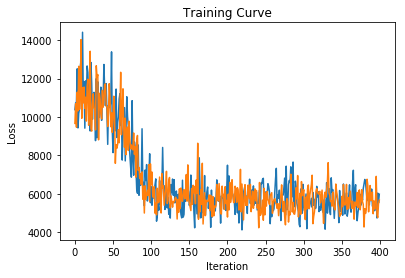

Iteration  400  | Loss:  6335.0126953125
Iteration  450  | Loss:  5210.00830078125
Iteration  500  | Loss:  5540.9541015625
Iteration  550  | Loss:  5309.9755859375


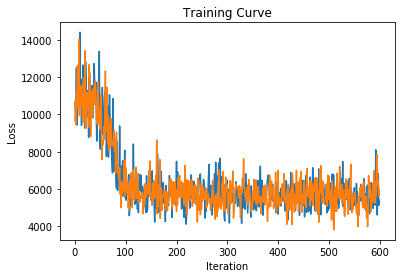

Iteration  600  | Loss:  5107.0419921875
Iteration  650  | Loss:  5131.9375
Iteration  700  | Loss:  5654.3125
Iteration  750  | Loss:  5776.30859375


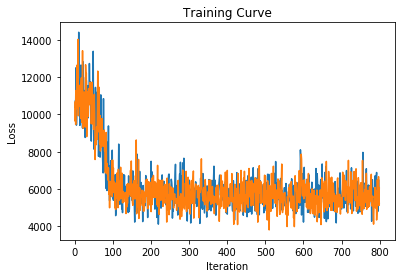

Iteration  800  | Loss:  5917.2333984375
Iteration  850  | Loss:  6213.56005859375
Iteration  900  | Loss:  6651.625
Iteration  950  | Loss:  5120.81640625


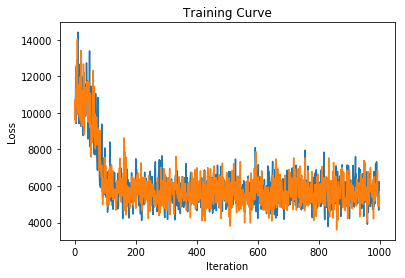

Iteration  1000  | Loss:  4741.78515625
Iteration  1050  | Loss:  5449.125
Iteration  1100  | Loss:  5627.6533203125
Iteration  1150  | Loss:  4533.7080078125


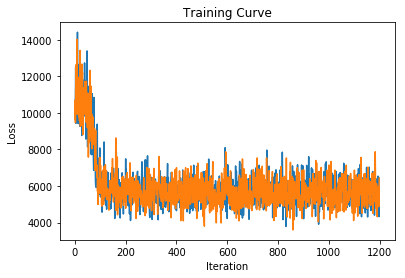

Iteration  1200  | Loss:  5157.33642578125


In [63]:
train_cuda(LSTM2, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4)

In [0]:
def loss_results(model, data_loader):
  MSE_criterion = nn.MSELoss()
  KL_criterion = nn.KLDivLoss()
  model.eval()
  chunk_length = 16000
  
  mse = []
  kl = []
  
  mse_recon = []
  kl_recon = []
  
  mse_separation = []
  kl_separation = []

  for batchData, (truth1, truth2) in data_loader:  
    pred = model(batchData.unsqueeze(1).float().cuda())

    pred1 = pred[:, chunk_length*0:chunk_length*1].float() * batchData.float().cuda()
    pred2 = pred[:, chunk_length*1:chunk_length*2].float() * batchData.float().cuda()

    mse_loss1 = MSE_criterion(pred1, truth1.float().cuda())
    mse_loss2 = MSE_criterion(pred2, truth2.float().cuda())

    mse_loss3 = MSE_criterion(pred1, truth2.float().cuda())
    mse_loss4 = MSE_criterion(pred2, truth1.float().cuda())
    
    MSE_chamfer_loss = min(mse_loss1 + mse_loss2, mse_loss3 + mse_loss4)
    
    KL_loss1 = abs(KL_criterion(pred1, truth1.float().cuda()))
    KL_loss2 = abs(KL_criterion(pred2, truth2.float().cuda()))

    KL_loss3 = abs(KL_criterion(pred1, truth2.float().cuda()))
    KL_loss4 = abs(KL_criterion(pred2, truth1.float().cuda()))

    KL_chamfer_loss = min(KL_loss1 + KL_loss2, KL_loss3 + KL_loss4)

    MSE_recon_loss = MSE_criterion(pred1 + pred2, batchData.float().cuda())
    KL_recon_loss = abs(KL_criterion(pred1 + pred2, batchData.float().cuda()))
    
    MSE_separation_loss = MSE_criterion(pred1, pred2)
    KL_separation_loss = abs(KL_criterion(pred1, pred2))

    
    mse.append((MSE_chamfer_loss.item())/len(batchData))
    kl.append((KL_chamfer_loss.item())/len(batchData))
    
    mse_recon.append((MSE_recon_loss.item())/len(batchData))
    kl_recon.append((KL_recon_loss.item())/len(batchData))
    
    mse_separation.append((MSE_separation_loss.item())/len(batchData))
    kl_separation.append((KL_separation_loss.item())/len(batchData))

  return np.array(mse).mean(), np.array(kl).mean(), np.array(mse_recon).mean(), np.array(kl_recon).mean(), np.array(mse_separation).mean(), np.array(kl_separation).mean()

In [86]:
loss_results(RNN, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


(6484.801836643449,
 3245.4287168204064,
 596.0191044451243,
 6472.950842432229,
 625.7582190823842,
 1546.0892113375376)

In [87]:
loss_results(LSTM2, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


(6398.351027155497,
 3611.828317371047,
 7.691166306690997,
 7164.935904555723,
 17.735153384381032,
 1758.6807355398153)

In [0]:
class KhaledNetLSTM_cuda(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetLSTM_cuda, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetLSTM_cuda"
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=10)
    self.conv = nn.Conv1d(1, 50, 100, stride=8)
    self.fc1 = nn.Linear(2550, 500)
    self.fc2 = nn.Linear(500,  input_size*4)

    self.dropout = nn.Dropout(0.5)

  
  def forward(self, x):
    h0 = torch.zeros(10, x.size(0), self.hidden_size).cuda()
    c0 = torch.zeros(10, x.size(0), self.hidden_size).cuda()
    output, _ = self.rnn(x, (h0, c0))
    output = F.relu(self.conv(self.dropout(output[:, -1, :].unsqueeze(1))))
    output = output.reshape(x.size(0), -1)
    output = F.relu(self.fc1(self.dropout(output)))
    output = self.fc2(self.dropout(output))
    return output

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration  50  | Loss:  14810.5908203125
Iteration  100  | Loss:  18020.33203125
Iteration  150  | Loss:  11797.15234375


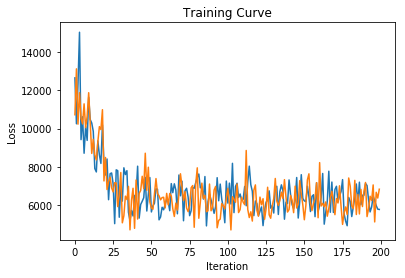

Iteration  200  | Loss:  15388.97265625
Iteration  250  | Loss:  16621.896484375
Iteration  300  | Loss:  16244.43359375


KeyboardInterrupt: ignored

In [0]:
model = KhaledNetLSTM_cuda(16000, 500)
train_cuda(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4)

In [88]:
output_results_cuda(LSTM2, test_loader)

[-414 -474 -515 ...  921  799  629]
[-461 -510 -572 ...  -13  -15   -8]
[ 47  36  57 ... 934 814 637]
[-227 -251 -269 ...  466  409  321]
[-184 -222 -246 ...  452  388  301]


In [0]:
class KhaledNetCNN_cuda(nn.Module):
  def __init__(self, input_size):
    super(KhaledNetCNN_cuda, self).__init__()
    self.name = "KhaledNetCNN_cuda"
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size= 10)
    self.conv2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size= 10)
    self.conv3 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size= 10)
    self.conv4 = nn.Conv1d(in_channels=10, out_channels=1, kernel_size= 10)
    self.fc1 = nn.Linear(124, input_size*4)

    self.dropout = nn.Dropout(0.5)

  
  def forward(self, x):
    output = F.relu(self.dropout(self.conv1(x)))
    output = F.relu(self.dropout(self.conv2(output)))
    output = F.relu(self.dropout(self.conv3(output)))
    output = F.relu(self.dropout(self.conv4(output)))
    output = output.reshape(x.size(0), -1)
    output = self.fc1(self.dropout(output))
    return output

In [0]:
model = KhaledNetCNN_cuda(160)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1992: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration  50  | Loss:  12711954.0
Iteration  100  | Loss:  9257989.0
Iteration  150  | Loss:  7569933.5


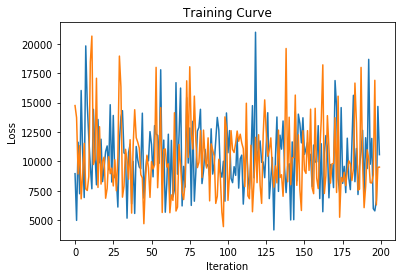

Iteration  200  | Loss:  424634.53125


KeyboardInterrupt: ignored

In [0]:
train_cuda(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-5)

In [0]:
output_results_cuda(model, train_loader)